지난 노트북의 경우, 탐색적 분석법의 접근법에 집중하여 데이터를 뜯어보고 시각화 해보았다.
이번 노트북의 경우, 같은 House Prices 데이터셋을 가지고 EDA부터 Modeling까지를 구현하였다.
이번 노트북을 통해서, EDA의 프로세스부터 ML 모델링의 단계까지 분석해보자.

원본 캐글 노트북 : https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

## Part 0 : Imports, Settings, Functions

In [88]:
import numpy as np
import pandas as pd
pd.set_option("max_columns", 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [89]:
# setting the number of cross validations used in the Model part
nr_cv = 5

# switch for using log values for SalePrice and features
use_logvals = 1

# target used for correlation
target = "SalePrice_Log"

# only columns with correlation above this threshold value
min_val_corr = 0.4

# switch for dropping columns that are similar to others already used and show a high correlation to these
drop_similar = 1

Here one can choose settings for optimal performance and runtime.
For example, nr_cv sets the number of cross validations used in GridsearchCV, and
min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).

In [90]:
# creation some useful functions
def get_best_score(grid):
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

def print_cols_large_corr(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    print(corr_abs.nlargest(nr_c, targ)[targ])
    
def plot_corr_matrix(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    
    plt.figure(figsize=(nr_c / 1.5, nr_c / 1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size":10},
                yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [91]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

## Part 1 : Exploratory data analysis

In [92]:
# shape, info, head and describe
print("train data shape: {}".format(df_train.shape))
print("test data shape: {}".format(df_test.shape))

train data shape: (1460, 81)
test data shape: (1459, 80)


In [93]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [94]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

- df train has 81 columns (79 features + id and target SalePrice) and 1460 entries (number of rows or house sales) 
- df test has 80 columns (79 features + id) and 1459 entries

- There is lots of info that is probably related to the SalePrice like the area, the neighborhood, the condition and quality.

- Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like GarageCars and GarageArea). 

- For some columns many values are missing: only 7 values for Pool QC in df train and 3 in df test

In [95]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [96]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [97]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [98]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Skewness: 1.8829
Kurtosis: 6.5363


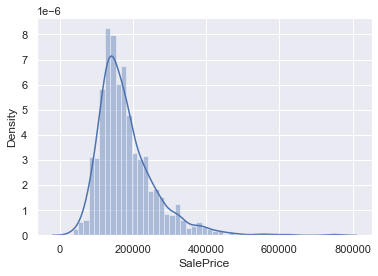

In [99]:
# target variable - distribution of SalePrice
sns.distplot(df_train["SalePrice"])

# skewness and kurtosis
print("Skewness: {0:.4f}".format(df_train["SalePrice"].skew()))
print("Kurtosis: {0:.4f}".format(df_train["SalePrice"].kurt()))

from the graph, we can find that "SalePrice" is not normally distributed. Therefore, preprocessing through standardization method like log transformation or standard scaling should be performed.

Skewness: 0.1213
Kurtosis: 0.8095


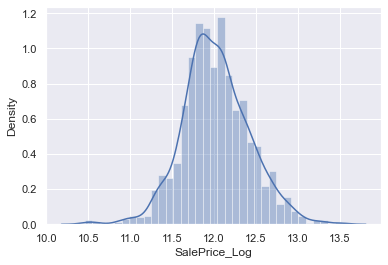

In [100]:
# log transformation
df_train["SalePrice_Log"] = np.log(df_train["SalePrice"])

# after log transformation, check the distribution, skewness, kurtosis
sns.distplot(df_train["SalePrice_Log"])
print("Skewness: {0:.4f}".format(df_train["SalePrice_Log"].skew()))
print("Kurtosis: {0:.4f}".format(df_train["SalePrice_Log"].kurt()))

# dropping old column
df_train.drop("SalePrice", axis=1, inplace=True)

In [101]:
# numerical and categorical features
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [102]:
print("Numerical features list")
print(df_train[numerical_feats].columns, "\n")

print("Categorical features list")
print(df_train[categorical_feats].columns)

Numerical features list
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object') 

Categorical features list
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposu

In [103]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,12.429216


In [104]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [105]:
# features that have missing values
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [106]:
# columns where NaN values have meaning
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace NaN to None in these columns
for col in cols_fillna:
    df_train[col].fillna("None", inplace=True)
    df_test[col].fillna("None", inplace=True)

- For a few columns there is lots of NaN entries.
- However, reading the data description we find this is not missing data
- For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc

In [107]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head()

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [108]:
# fillna with mean for the remaining columns : LotFrontage, GarageYrBlt, MasVnrArea
fillna_cols = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
df_train[fillna_cols] = df_train[fillna_cols].fillna(df_train[fillna_cols].mean())
df_test[fillna_cols] = df_test[fillna_cols].fillna(df_train[fillna_cols].mean())

In [109]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(10)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0


In [110]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(10)

,Total,Percent
BsmtFullBath,2,0.001371
BsmtHalfBath,2,0.001371
GarageCars,1,0.000685
TotalBsmtSF,1,0.000685
BsmtUnfSF,1,0.000685
BsmtFinSF2,1,0.000685
GarageArea,1,0.000685
BsmtFinSF1,1,0.000685
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [111]:
# filling NaN in the test data by train data mean value
fillna_cols = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'TotalBsmtSF','BsmtUnfSF', 
               'BsmtFinSF2', 'GarageArea', 'BsmtFinSF1']
df_test[fillna_cols] = df_test[fillna_cols].fillna(df_train[fillna_cols].mean())

In [112]:
# missing values in train data?
df_train.isnull().sum().sum()

0

In [113]:
# missing values in test data?
df_test.isnull().sum().sum()

0

In [114]:
# check numerical features's normality through skewness and kurtosis
for col in numerical_feats:
    print("{:15}".format(col),
          "Skewness: {:.4f}".format(df_train[col].skew()),
          "    ",
          "Kurtosis: {:.4f}".format(df_train[col].kurt()))

Id              Skewness: 0.0000      Kurtosis: -1.2000
MSSubClass      Skewness: 1.4077      Kurtosis: 1.5802
LotFrontage     Skewness: 2.3850      Kurtosis: 21.8482
LotArea         Skewness: 12.2077      Kurtosis: 203.2433
OverallQual     Skewness: 0.2169      Kurtosis: 0.0963
OverallCond     Skewness: 0.6931      Kurtosis: 1.1064
YearBuilt       Skewness: -0.6135      Kurtosis: -0.4396
YearRemodAdd    Skewness: -0.5036      Kurtosis: -1.2722
MasVnrArea      Skewness: 2.6764      Kurtosis: 10.1543
BsmtFinSF1      Skewness: 1.6855      Kurtosis: 11.1182
BsmtFinSF2      Skewness: 4.2553      Kurtosis: 20.1133
BsmtUnfSF       Skewness: 0.9203      Kurtosis: 0.4750
TotalBsmtSF     Skewness: 1.5243      Kurtosis: 13.2505
1stFlrSF        Skewness: 1.3768      Kurtosis: 5.7458
2ndFlrSF        Skewness: 0.8130      Kurtosis: -0.5535
LowQualFinSF    Skewness: 9.0113      Kurtosis: 83.2348
GrLivArea       Skewness: 1.3666      Kurtosis: 4.8951
BsmtFullBath    Skewness: 0.5961      Kurtosis: -0

Skewness: 1.366560
Kurtosis: 4.895121


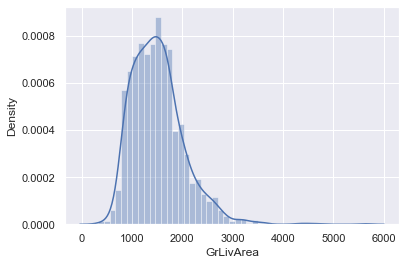

In [115]:
sns.distplot(df_train["GrLivArea"])
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


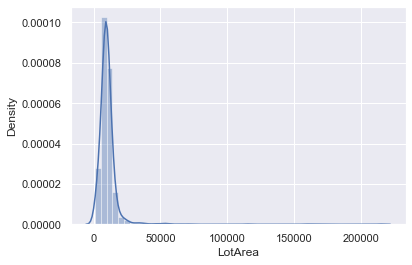

In [116]:
# peakedness distribution example
sns.distplot(df_train['LotArea']);
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [117]:
for df in [df_train, df_test]:
    df["GrLivArea_Log"] = np.log(df["GrLivArea"])
    df.drop("GrLivArea", inplace=True, axis=1)
    df["LotArea_Log"] = np.log(df["LotArea"])
    df.drop("LotArea", inplace=True, axis=1)
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: -0.006995
Kurtosis: 0.282603


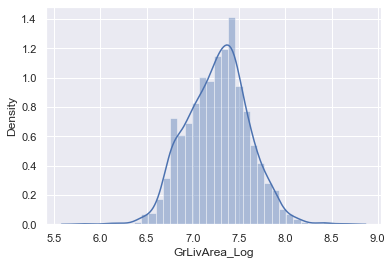

In [118]:
sns.distplot(df_train["GrLivArea_Log"])
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


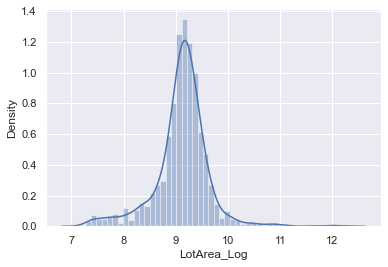

In [119]:
sns.distplot(df_train['LotArea_Log'])
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

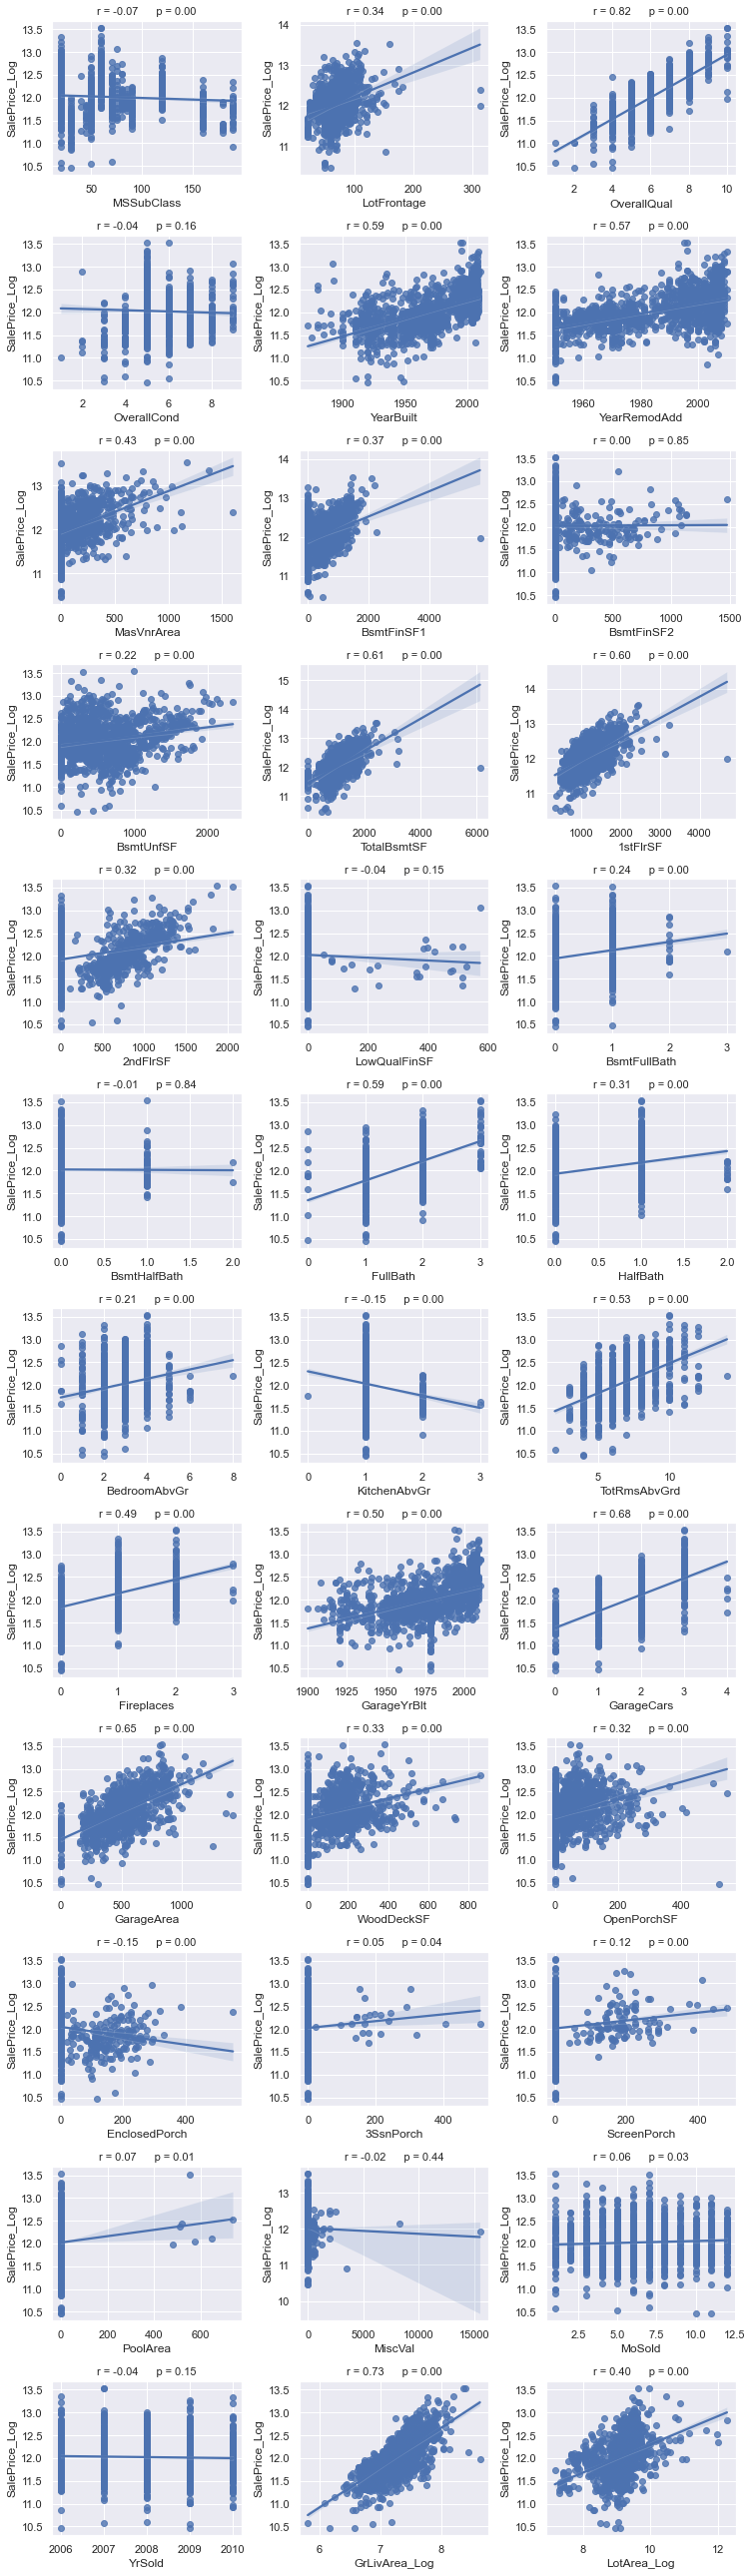

In [120]:
# relation of features to target variable
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ["Id", "SalePrice","SalePrice_Log"]
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax=axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)
plt.tight_layout()
plt.show()

### Conclusion from EDA on numerical columns

- 타겟 피처와 강한 상관 관계를 띄는 피처들을 시각화하여 확인 할 수 있다.
- SalePrice와 상관 관계의 임계값을 셋팅 코드에서 설정한 값에 따라 독립 변수들의 활용여부를 결정할 수 있다.
- 숫자형 피처들 중에 실제 값이 의미하는 것이 카테고리 그룹인 피처들을 확인 할 수 있다. 'OverallQual', "MSSubClass"

In [121]:
# outliers
df_train = df_train.drop(df_train[(df_train["OverallQual"]==10) & (df_train["SalePrice_Log"]<12.3)].index)

In [122]:
df_train = df_train.drop(df_train[(df_train["GrLivArea_Log"]>8.3) & (df_train["SalePrice_Log"]<12.5)].index)

In [123]:
# find columns with strong correlation to target
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [124]:
# list of numerical features and corrleation coefficient to target
print(ser_corr, "\n")
print("List of numerical features with r above min_val_corr: ")
print(cols_abv_corr_limit, "\n")
print("List of numerical features with r below min_val_corr: ")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

In [125]:
# list of categorical features and their unique values
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print("#" * 50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

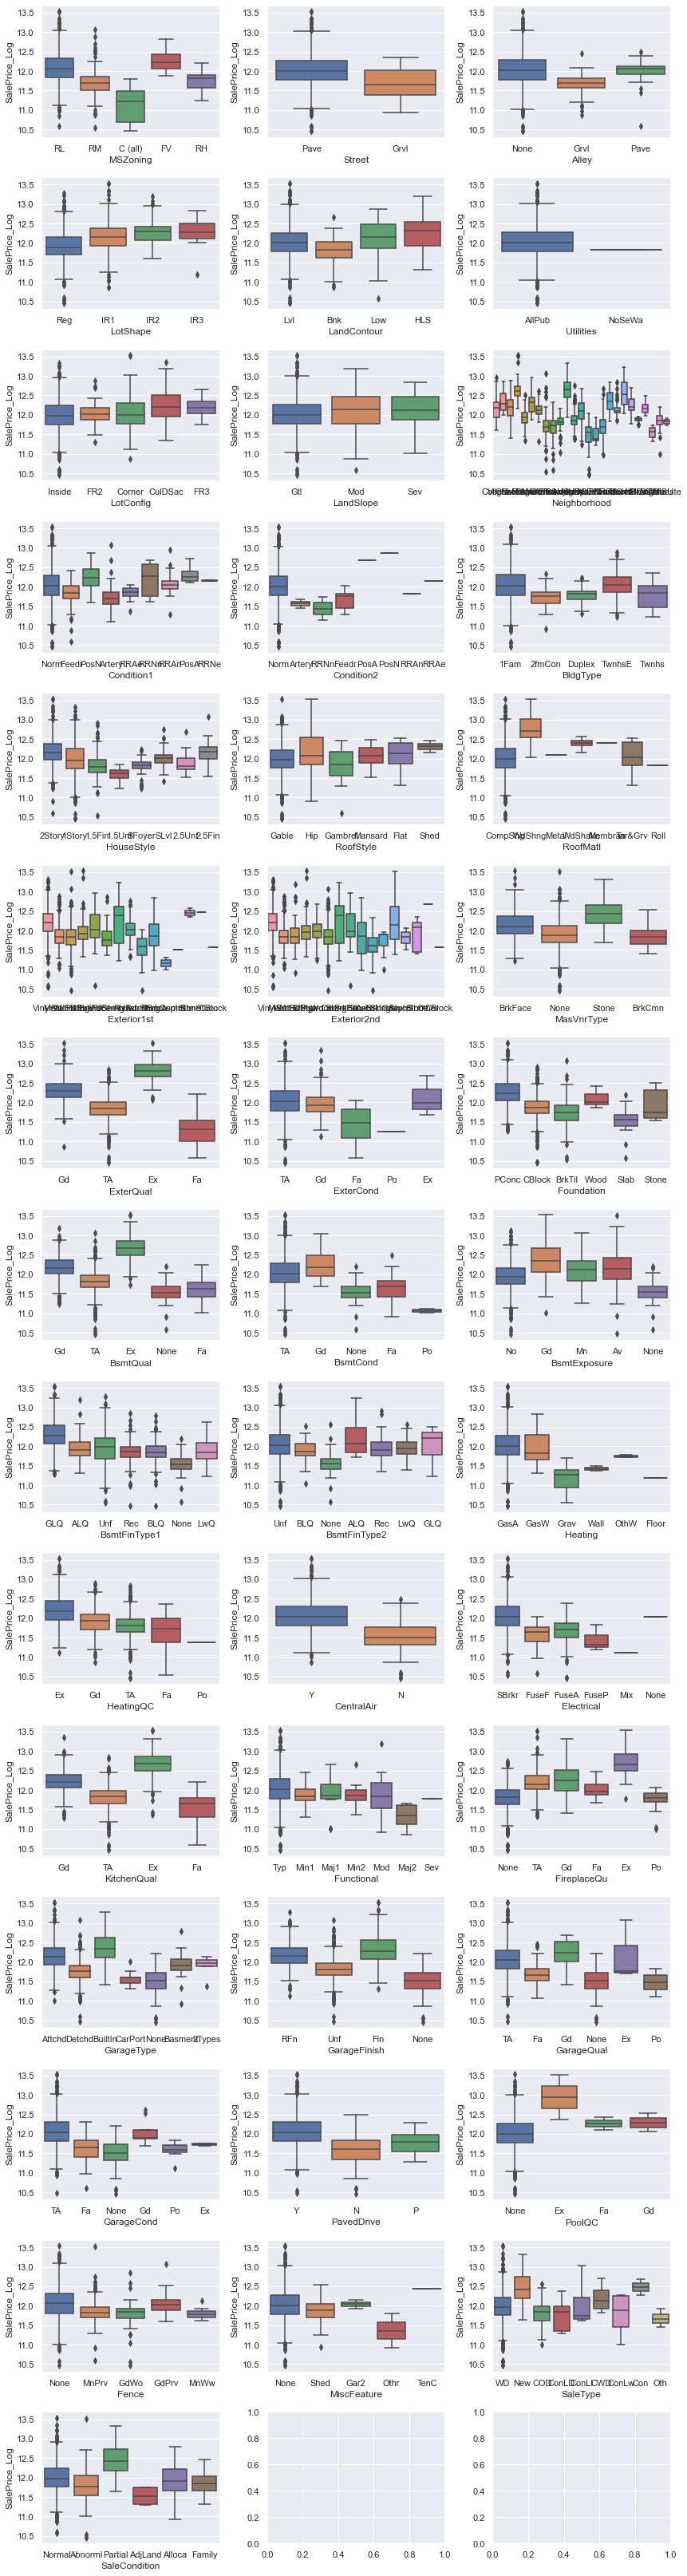

In [126]:
# relation to SalePrice for all categorical features
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax=axs[r][c])
plt.tight_layout()
plt.show()

### Conclusion from EDA on categorical columns
- 대부분의 카테고리 피처들의 경우, SalePrice와 강한 상관 관계를 띄지는 않는다.
- 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType' 피처들의 경우, 상관 관계의 패턴을 파악할 수 있다.
- 박스 플롯에서 상관 관계를 해석하는 방법 중에 하나는 데이터 그룹 간의 중앙값의 변화를 보는 것이다.

In [127]:
catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition']

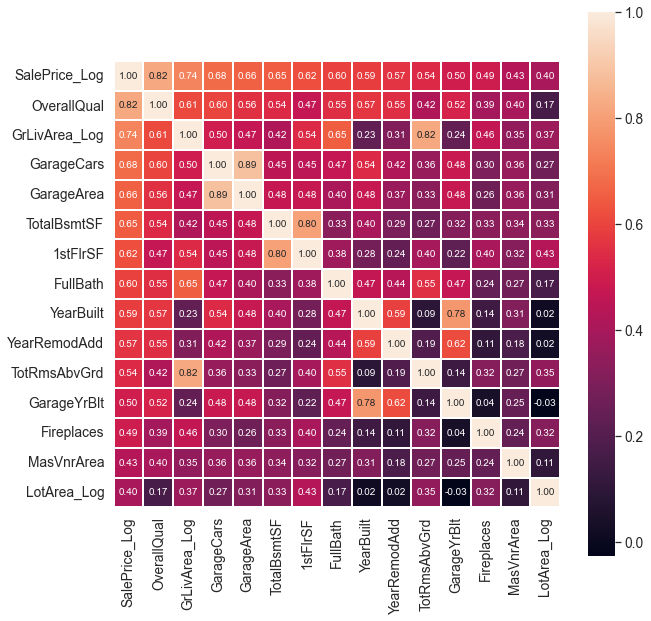

In [128]:
# features with largest correlation to SalePrice_Log
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target)

- 높은 상관 관계를 띈 피처들을 파악할 수 있다.
- 히트맵에서 고려해야 할 점은 다중공선성을 띄는 피처들의 관계 또한 파악하는 것이다.
- GarageCars & GarageArea, YearBuilt & GarageYrBlt, TotalBsmtSf & 1stFlrSF, TotRmsAbvGrd & GrLivArea_Log etc

#### To be continued (다음 포스트에서 계속)

## Part 2 : Data wrangling

- SalePrice와 낮은 상관 관계를 띄는 피처들을 제거
- 카테고리 피처를 숫자형 피처로 변환
- 결측치 처리
- Log 값 처리
- 같은 결의 피처들을 제거하여 다중공선성 영향력 감소

In [129]:
# dropping all columns with weak correlation to Saleprice
id_test = df_test["Id"]

to_drop_num = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ["Id"] + to_drop_num + to_drop_catg

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

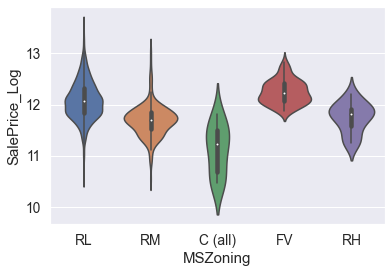

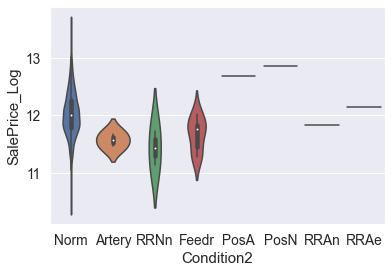

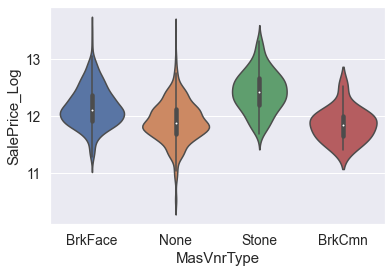

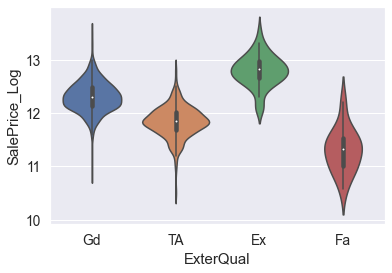

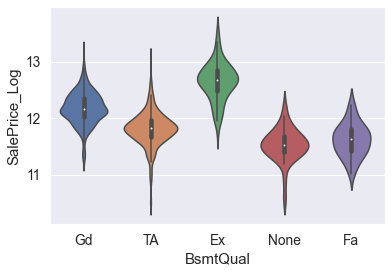

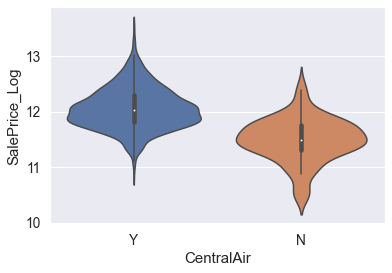

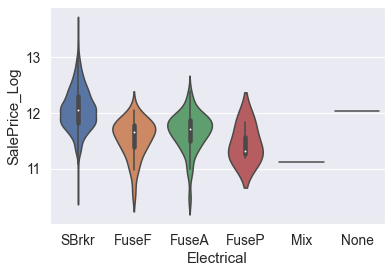

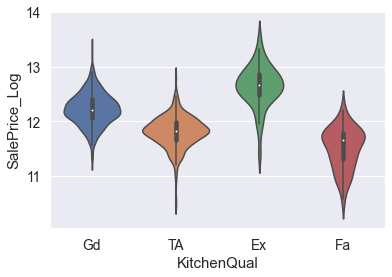

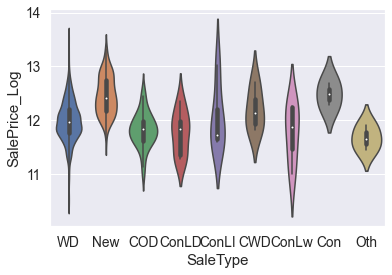

In [130]:
# visualization categorical features with violin plot
catg_list = catg_strong_corr.copy()
catg_list.remove("Neighborhood") # Neighborhood 피처는 카테고리 종류가 다양하므로 따로 빼서 시각화

for catg in catg_list:
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()

In [131]:
df_train["Condition2"].value_counts()

Norm      1444
Feedr        6
Artery       2
RRNn         2
PosA         1
PosN         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

#### 바이올린 플롯의 분포에서 알 수 있는점
- 대부분의 피처들이 중앙값 주변에서 많든 데이터들이 분포하고 있음을 볼 수 있다.
- Condition2 피처의 경우 Norm 카테고리 외에는 나머지 카테고리는 희소한 개수의 값들만 가지고 있음.
- 카테고리 피처들의 SalePrice 평균값, 중앙값을 대표값으로 활용해도 통계적으로 무리가 없다고 판단할 수 있음.

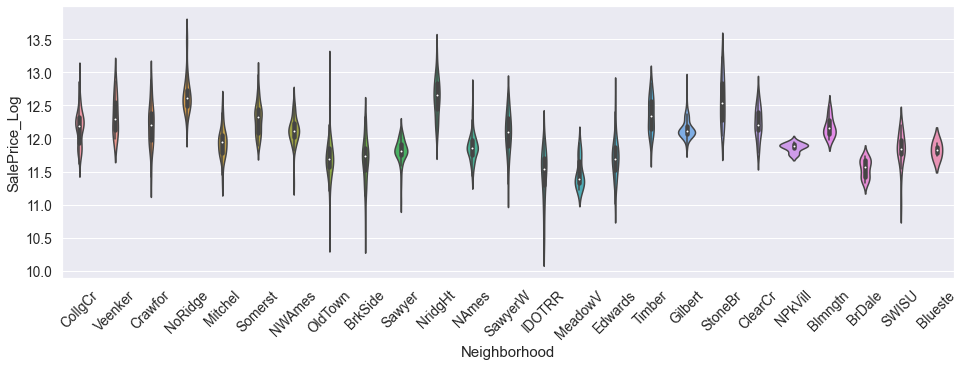

In [132]:
# Neighborhood 피처의 바이올린 플롯 시각화
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x="Neighborhood", y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [133]:
df_train["Neighborhood"].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [134]:
# 카테고리 피처의 속한 각 카테고리 값의 평균 SalePrice
for catg in catg_list:
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [135]:
# 평균값이 비슷한 카테고리 값들끼리 묶기

# MSZoning
msz_catg2 = ["RM", "RH"]
msz_catg3 = ["RL", "FV"]

# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [136]:
# 묶은 카테고리 그룹에 숫자 레이블 달기
for df in [df_train, df_test]:
    
    df["MSZ_num"] = 1
    df.loc[(df["MSZoning"].isin(msz_catg2)), "MSZ_num"] = 2
    df.loc[(df["MSZoning"].isin(msz_catg3)), "MSZ_num"] = 3
    
    df["NbHd_num"] = 1
    df.loc[(df["Neighborhood"].isin(nbhd_catg2)), "NbHd_num"] = 2
    df.loc[(df["Neighborhood"].isin(nbhd_catg3)), "NbHd_num"] = 3
    
    df["Cond2_num"] = 1
    df.loc[(df["Condition2"].isin(cond2_catg2)), "Cond2_num"] = 2
    df.loc[(df["Condition2"].isin(cond2_catg3)), "Cond2_num"] = 3
    
    df["Mas_num"] = 1
    df.loc[(df["MasVnrType"] == "Stone"), "Mas_num"] = 2

    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 

    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4 

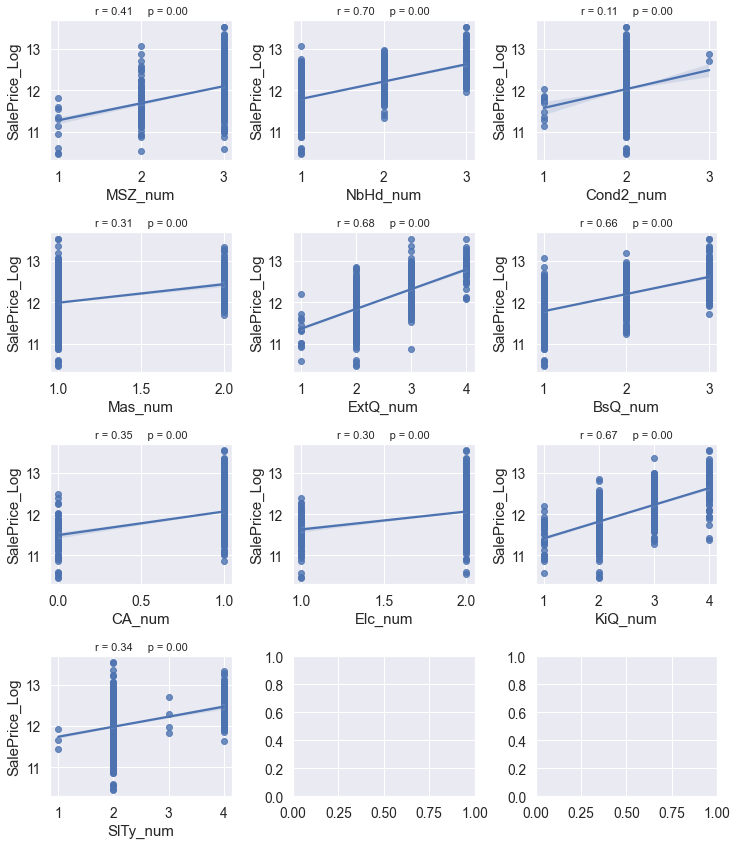

In [137]:
# 새롭게 변환한 카테고리 피처들의 SalePrice와의 상관관계 그래프로 시각화
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target], ax=axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "     " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)

plt.tight_layout()
plt.show()

- 시각화에서 알 수 있듯이, 변환된 피처들이 SalePrice와 상관 관계가 개선된 것을 확인할 수 있다.

In [138]:
# drop the converted categorical columns and the new numerical columns with weak correlation
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

for df in [df_train, df_test]:
    df.drop(catg_cols_to_drop, inplace=True, axis=1)
    df.drop(cols_bel_corr_limit_1, inplace=True, axis=1)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
CA_num           0.351598
SlTy_num         0.337469
Mas_num          0.313280
Elc_num          0.304857
Cond2_num        0.107610
Name: SalePrice_Log, dtype: float64


In [139]:
# columns and correlation after dropping
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


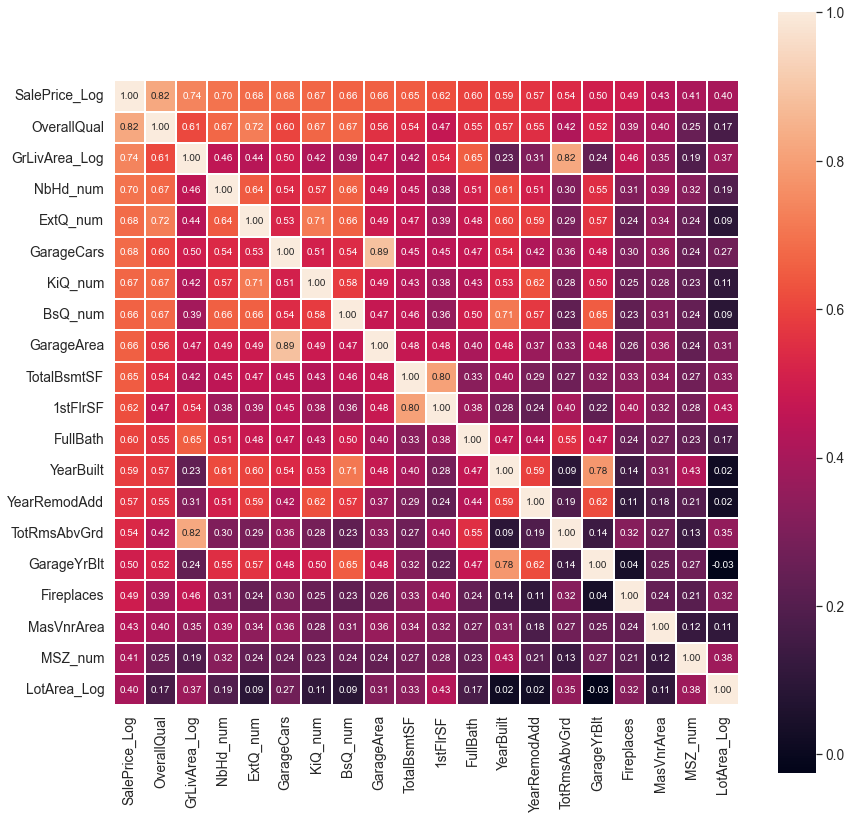

In [140]:
# 히트맵 시각화 (강한 상관 관계 피처들과 SalePrice)
nr_feats = len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

#### Multicollinearity 체크
- 강한 상관 관계를 띄는 피처들 중 결이 같은 피처들 중 선택하여 제거해야 한다.
- 'GrLivArea_Log' and 'TotRmsAbvGrd', 'GarageCars' and 'GarageArea'
- 'TotalBsmtSF' and '1stFlrSF', 'YearBuilt' and 'GarageYrBlt'
- 위의 4가지 중에 상대적으로 SalePrice와 상관 관계가 낮은 피처를 선택하여 제거.

In [141]:
# 선택적 제거
cols = corr_abs_2.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1:
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt']:
        if col in cols:
            cols.remove(col)
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [142]:
# SalePrice_Log 타겟 피처 피처 리스트에서 제거하기
feats = cols.copy()
feats.remove("SalePrice_Log")

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [148]:
# 모델 학습용 데이터셋 복사
df_train_ml = df_train[feats].copy()
df_test_ml = df_test[feats].copy()

y = df_train[target]

In [149]:
df_train_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1458 non-null   int64  
 1   GrLivArea_Log  1458 non-null   float64
 2   NbHd_num       1458 non-null   int64  
 3   ExtQ_num       1458 non-null   int64  
 4   GarageCars     1458 non-null   int64  
 5   KiQ_num        1458 non-null   int64  
 6   BsQ_num        1458 non-null   int64  
 7   TotalBsmtSF    1458 non-null   int64  
 8   FullBath       1458 non-null   int64  
 9   YearBuilt      1458 non-null   int64  
 10  YearRemodAdd   1458 non-null   int64  
 11  Fireplaces     1458 non-null   int64  
 12  MasVnrArea     1458 non-null   float64
 13  MSZ_num        1458 non-null   int64  
 14  LotArea_Log    1458 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 214.5 KB


In [150]:
df_test_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1459 non-null   int64  
 1   GrLivArea_Log  1459 non-null   float64
 2   NbHd_num       1459 non-null   int64  
 3   ExtQ_num       1459 non-null   int64  
 4   GarageCars     1459 non-null   float64
 5   KiQ_num        1459 non-null   int64  
 6   BsQ_num        1459 non-null   int64  
 7   TotalBsmtSF    1459 non-null   float64
 8   FullBath       1459 non-null   int64  
 9   YearBuilt      1459 non-null   int64  
 10  YearRemodAdd   1459 non-null   int64  
 11  Fireplaces     1459 non-null   int64  
 12  MasVnrArea     1459 non-null   float64
 13  MSZ_num        1459 non-null   int64  
 14  LotArea_Log    1459 non-null   float64
dtypes: float64(5), int64(10)
memory usage: 171.1 KB


In [151]:
# Standard Scaler 적용
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [152]:
# 모델 학습용 데이터셋 설정
X_train_sc = df_train_ml_sc.copy()
X_test_sc = df_test_ml_sc.copy()
y_train_sc = df_train[target]

## Part 3 : Various regression models and comparision of results

In [154]:
from sklearn.model_selection import GridSearchCV
score_metrics = "neg_mean_squared_error"

In [185]:
# Linear Regression model
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {"fit_intercept":[True, False], "normalize":[True, False], "copy_X":[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1, scoring=score_metrics)
grid_linear.fit(X_train_sc, y_train_sc)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.13623337683103734
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)


In [186]:
linreg_best = grid_linear.best_estimator_
pred_linreg = linreg_best.predict(X_test_sc)

In [187]:
# Ridge
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_metrics)
grid_ridge.fit(X_train_sc, y_train_sc)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.13620747796635566
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, normalize=True, tol=1e-06)


In [188]:
ridge_best = grid_ridge.best_estimator_
pred_ridge = ridge_best.predict(X_test_sc)

In [189]:
# Lasso
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_metrics)
grid_lasso.fit(X_train_sc, y_train_sc)

sc_lasso = get_best_score(grid_lasso)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.13626471184077182
{'alpha': 0.001, 'normalize': False, 'tol': 5e-05}
Lasso(alpha=0.001, normalize=False, tol=5e-05)


In [190]:
lasso_best = grid_lasso.best_estimator_
pred_lasso = lasso_best.predict(X_test_sc)

In [191]:
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_metrics)
grid_enet.fit(X_train_sc, y_train_sc)

sc_enet = get_best_score(grid_enet)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.1371848369685215
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.01}
ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000, normalize=False,
           tol=0.01)


In [192]:
enet_best = grid_enet.best_estimator_
pred_enet = enet_best.predict(X_test_sc)

In [193]:
# SGD Regressor
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]}
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_metrics)
grid_sgd.fit(X_train_sc, y_train_sc)

sc_sgd = get_best_score(grid_sgd)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.1367022632438854
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


In [194]:
sgd_best = grid_sgd.best_estimator_
pred_sgd = sgd_best.predict(X_test_sc)

In [195]:
# DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor

dtree_reg = DecisionTreeRegressor()
param_grid = {'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],}
grid_dtree = GridSearchCV(dtree_reg, param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_metrics)
grid_dtree.fit(X_train_sc, y_train_sc)

sc_dtree_reg = get_best_score(grid_dtree)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.18298055764398063
{'max_depth': 7, 'max_features': 13, 'max_leaf_nodes': None, 'min_samples_split': 30}
DecisionTreeRegressor(max_depth=7, max_features=13, min_samples_split=30)


In [196]:
dtree_best = grid_dtree.best_estimator_
pred_dtree = dtree_best.predict(X_test_sc)

In [197]:
# RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100]}
grid_rf = GridSearchCV(rf_reg, param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_metrics)
grid_rf.fit(X_train_sc, y_train_sc)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.1454882163379738
{'min_samples_split': 4, 'n_estimators': 100}
RandomForestRegressor(min_samples_split=4)


In [198]:
rf_reg_best = grid_rf.best_estimator_
pred_rf_reg = rf_reg_best.predict(X_test_sc)

In [199]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(knn_reg, param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_metrics)
grid_knn.fit(X_train_sc, y_train_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
0.15614699237334775
{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', weights='distance')


In [200]:
knn_reg_best = grid_knn.best_estimator_
pred_knn_reg = knn_reg_best.predict(X_test_sc)

In [201]:
# Gaussian Process Regressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=nr_cv, verbose=1, scoring = score_metrics)
grid_gpr.fit(X_train_sc, y_train_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\HYUNJUN\anaconda3\envs\deep-learning-gpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:596: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\HYUNJUN\anaconda3\envs\deep-learning-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
C:\Users\HYUNJUN\anaconda3\envs\deep-learning-gpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:596: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit

0.13623340081720955
{'kernel': DotProduct(sigma_0=1), 'normalize_y': False}
GaussianProcessRegressor(alpha=5e-09, kernel=DotProduct(sigma_0=1),
                         random_state=5)


In [202]:
gpr_best = grid_knn.best_estimator_
pred_gpr = gpr_best.predict(X_test_sc)

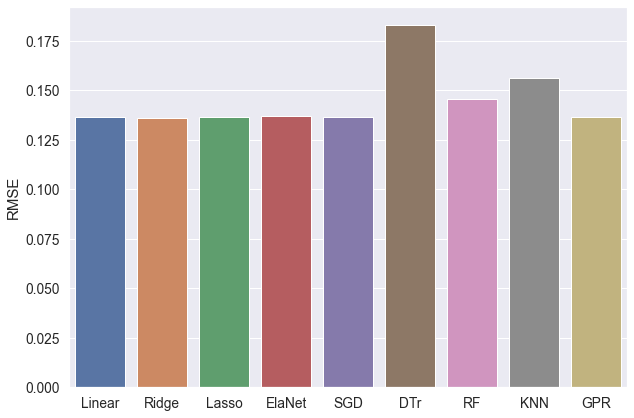

In [203]:
# comparasion plot with RMSE of all models
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet, sc_sgd, sc_dtree_reg, sc_rf, sc_knn, sc_gpr]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

In [206]:
# correlation model results
predictions = {'Linear': pred_linreg, 'Ridge': pred_ridge, 'Lasso': pred_lasso,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf_reg,
               'KNN': pred_knn_reg, 'GPR': pred_gpr}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,DTr,RF,KNN,GPR
Linear,1.000000,0.999988,0.999970,0.999343,0.999885,0.934119,0.980287,0.964421,0.964421
Ridge,0.999988,1.000000,0.999979,0.999495,0.999906,0.934149,0.980231,0.964846,0.964846
Lasso,0.999970,0.999979,1.000000,0.999526,0.999847,0.934259,0.980453,0.964579,0.964579
ElaNet,0.999343,0.999495,0.999526,1.000000,0.999388,0.934604,0.979962,0.966555,0.966555
SGD,0.999885,0.999906,0.999847,0.999388,1.000000,0.934208,0.979812,0.964849,0.964849
DTr,0.934119,0.934149,0.934259,0.934604,0.934208,1.000000,0.942681,0.910977,0.910977
RF,0.980287,0.980231,0.980453,0.979962,0.979812,0.942681,1.000000,0.962378,0.962378
KNN,0.964421,0.964846,0.964579,0.966555,0.964849,0.910977,0.962378,1.000000,1.000000
GPR,0.964421,0.964846,0.964579,0.966555,0.964849,0.910977,0.962378,1.000000,1.000000


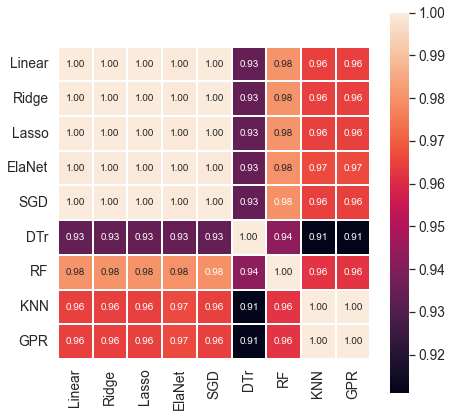

In [207]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns)
plt.show()

In [233]:
sub_mean = pd.DataFrame()
sub_mean["Id"] = id_test
sub_mean["SalePrice"] = np.round(np.exp(((pred_enet + pred_rf_reg + pred_gpr + pred_lasso) / 4.0)), decimals=4)
sub_mean["SalePrice"] = sub_mean["SalePrice"].astype(float)
sub_mean.to_csv("ensemble_model.csv", index=False)